# 1. Install Dependencies and Setup

In [1]:
!pip install opencv-python matplotlib

In [2]:
!pip list tensorflow

Package                      Version
---------------------------- --------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.50.0
gast                         0.4.0
google-auth                  2.29.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.62.1
h5py                         3.10.0
idna                         3.6
importlib_metadata           7.1.0
ipykernel                    6.29.3
ipython                      8.22.2
jedi 

In [3]:
import tensorflow as tf
import os
print("done")

done


In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 463 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

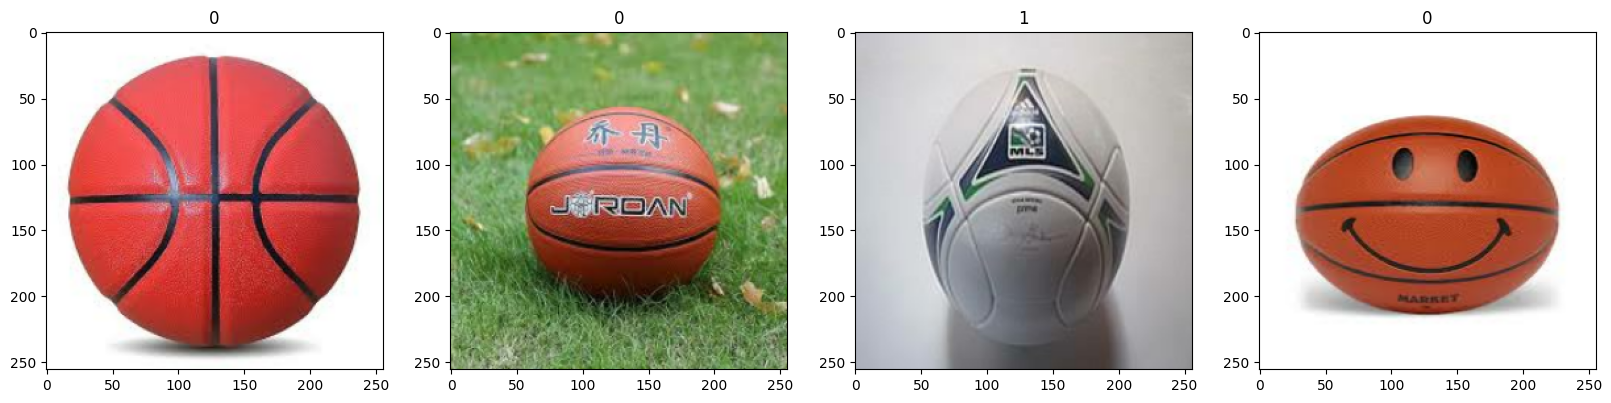

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

Scaling the data using .map function to scale the images as they go throught the pipline

In [15]:
scale_data = data.map(lambda x,y: (x/255, y))

In [16]:
scale_data.as_numpy_iterator().next()
print(len(scale_data))

15


In [17]:
# Assuming scale_data is your dataset
data_iterator = scale_data.as_numpy_iterator()

# Initialize a list to store the mean values of each batch
mean_values = []

# Loop through each batch in the dataset
for batch in data_iterator:
    # Extract input data from the batch
    input_data = batch[0]
    
    # Calculate the mean of the current batch
    batch_mean = np.mean(input_data)
    
    # Append the mean value to the list
    mean_values.append(batch_mean)

# Calculate the overall mean value by averaging the mean values of all batches
overall_mean = np.mean(mean_values)

print("Overall mean value:", overall_mean, mean_values)


Overall mean value: 0.62372184 [0.60866696, 0.5992187, 0.65459967, 0.55326635, 0.593224, 0.66234905, 0.61592716, 0.64241135, 0.61328155, 0.69538903, 0.614256, 0.6305776, 0.58006805, 0.6202697, 0.67232275]


In [18]:
len(scale_data)

15

# 5. Split Data

In [19]:
train_size = int(len(scale_data)*.7)
val_size = int(len(scale_data)*.2)
test_size = int(len(scale_data)*.1)+1 

In [20]:

test_size + train_size + val_size

15

In [21]:
train_size

10

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
# Sequential
# Conv2D, 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [25]:
model = Sequential()

In [26]:
# Adding a Convolutional 2D layer with 16 filters of size (3,3), using a stride of 1 and ReLU activation function.
# The input shape of the images is (256,256,3) where 3 represents the number of channels (RGB).
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

# Adding a MaxPooling layer to downsample the spatial dimensions.
model.add(MaxPooling2D())

# Adding another Convolutional 2D layer with 32 filters of size (3,3), using a stride of 1 and ReLU activation function.
model.add(Conv2D(32, (3,3), 1, activation='relu'))

# Adding another MaxPooling layer to further downsample the spatial dimensions.
model.add(MaxPooling2D())

# Adding another Convolutional 2D layer with 16 filters of size (3,3), using a stride of 1 and ReLU activation function.
model.add(Conv2D(16, (3,3), 1, activation='relu'))

# Adding another MaxPooling layer to further downsample the spatial dimensions.
model.add(MaxPooling2D())

# Flattening the output of the previous layer to prepare it for the fully connected layers.
model.add(Flatten())

# Adding a fully connected Dense layer with 256 neurons and ReLU activation function.
model.add(Dense(256, activation='relu'))

# Adding the output layer with a single neuron and Sigmoid activation function, which outputs probabilities.
model.add(Dense(1, activation='sigmoid'))

In [27]:
# the model with the Adam optimizer, binary cross-entropy loss function, and accuracy as the evaluation metric. 
#After compilation, the model is ready to be trained on a dataset using the specified optimizer, 
# loss function, and evaluation metric. 

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


10/10 [==============================] - 13s 269ms/step - loss: 268.8166 - accuracy: 0.5094 - val_loss: 21.6668 - val_accuracy: 0.5729
Epoch 2/20
10/10 [==============================] - 3s 228ms/step - loss: 4.6083 - accuracy: 0.6656 - val_loss: 1.0118 - val_accuracy: 0.8333
Epoch 3/20
10/10 [==============================] - 3s 241ms/step - loss: 0.7343 - accuracy: 0.8250 - val_loss: 0.6209 - val_accuracy: 0.7396
Epoch 4/20
10/10 [==============================] - 3s 230ms/step - loss: 0.4655 - accuracy: 0.7781 - val_loss: 0.3448 - val_accuracy: 0.9167
Epoch 5/20
10/10 [==============================] - 3s 222ms/step - loss: 0.3583 - accuracy: 0.8875 - val_loss: 0.3264 - val_accuracy: 0.8646
Epoch 6/20
10/10 [==============================] - 3s 222ms/step - loss: 0.2550 - accuracy: 0.9125 - val_loss: 0.2492 - val_accuracy: 0.8958
Epoch 7/20
10/10 [==============================] - 3s 236ms/step - loss: 0.2035 - accuracy: 0.9187 - val_loss: 0.1685 - val_accuracy: 0.9271
Epoch 8/20
10

# 8. Plot Performance

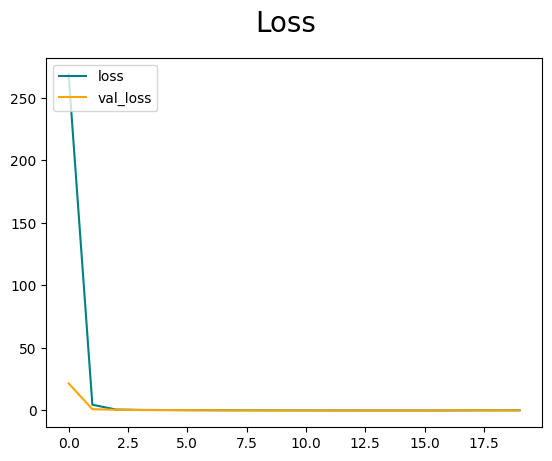

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

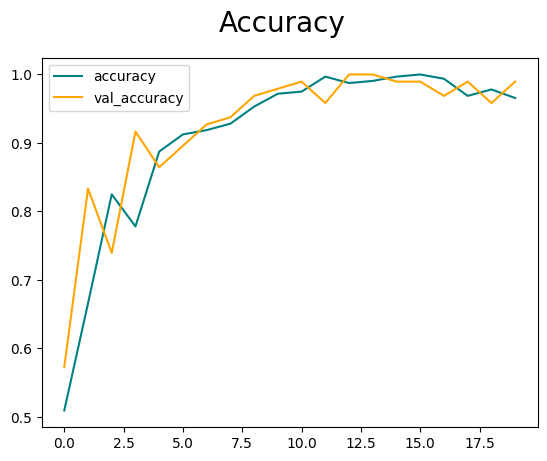

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 532ms/step


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.95238096, shape=(), dtype=float32) tf.Tensor(0.9787234, shape=(), dtype=float32)


# 10. Test

In [38]:
import cv2

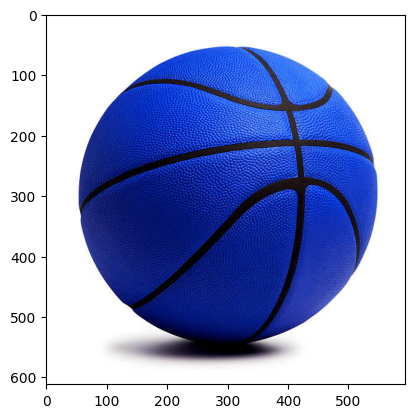

In [48]:
img = cv2.imread('one.jpeg')
plt.imshow(img)
plt.show()

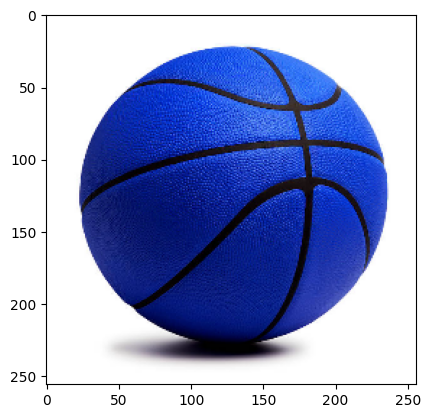

In [49]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [50]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 29ms/step


In [51]:
yhat

array([[0.50960356]], dtype=float32)

In [52]:
if yhat > 0.5: 
    print(f'Predicted class is football')
    print(yhat)
else:
    print(f'Predicted class is basketball')
    print(yhat)

Predicted class is football
[[0.50960356]]


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','models/imageclassifier1.h5'))

In [46]:
new_model = load_model('models/imageclassifier1.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 101ms/step


array([[0.9999865]], dtype=float32)